# Project 4
# Report on U.S. Health Insurance Marketplace 

## Instruction

### The datasets we used in this report contain data on health and dental plans offered to individuals and small businesses through the US Health Insurance Marketplace. This data was originally prepared and released by the Centers for Medicare & Medicaid Services (CMS), which is part of the U.S. Department of Health and Human Services (HHS). In this report we try to find some useful information to support the CMS work. You can watch a short video to get to know about CMS's work, mission, and vision. And you can find the data dictionary for this report in the attached document.

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('Kahh9MO8lYE')

#### We can also make a summary for you to introduce our dataset background by Python. (NLP)

In [2]:
import os
import sys
import json
#import feedparser
import requests
import pandas as pd
from nltk import clean_html
import urllib2
from bs4 import BeautifulSoup as bs

massey_proxies = {
  "http": "http://alb-cache.massey.ac.nz/",
  "https": "http://alb-cache.massey.ac.nz/",
}

In [3]:
import nltk

In [4]:
nltk.set_proxy('http://alb-cache.massey.ac.nz/:8080', ('12161115', 'pasword'))
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [5]:
from IPython.core.display import HTML
HTML("<iframe src=https://www.cms.gov/cciio/resources/data-resources/marketplace-puf.html width=1000 height=350></iframe>")

In [6]:
HTML_PAGE = 'https://www.cms.gov/cciio/resources/data-resources/marketplace-puf.html'
response = requests.get(HTML_PAGE, proxies=massey_proxies) # Maybe error out of Massey University
page = response.content

#### Clean text:

In [7]:
bs_object = bs(page, "lxml")  
raw = bs_object.get_text()
start = raw.find('The Centers for Medicare')
end = raw.find(' formulary information')
cleaned = raw[start : end + len(' formulary information')]
cleaned_article = cleaned.replace('\n', '')
cleaned_str = cleaned_article.encode('ascii','ignore')
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer('\w+')
cleaned_str[:1000]

'The Centers for Medicare & Medicaid Services (CMS) Center for Consumer Information and Insurance Oversight (CCIIO) is committed to increasing transparency in the Health Insurance Marketplace. While health plan information including benefits, copayments, premiums, and geographic coverage is publically available on Healthcare.gov, CMS has also released downloadable public use files (PUFs) so that researchers and other stakeholders can more easily access Marketplace data.The Health Insurance Marketplace Public Use Files (Marketplace PUF) are available for plan years 2014 through 2016 to support timely benefit and rate analysis. It is important to note that the 2016 Marketplace PUF will be updated regularly to reflect the plan data that consumers will see when shopping for a Marketplace Qualified Health Plan (QHP). Data for the 2016 Marketplace PUF were imported to CMS systems on April 22, 2016. The 2015 Marketplace PUF data were imported to CMS systems on July 24, 2015, and the 2014 Mark

#### Text summarization 

In [8]:
import sys
import json
import nltk
import numpy

N = 50  # Number of words to consider
CLUSTER_THRESHOLD = 5  # Distance between words to consider
TOP_SENTENCES = 3  # Number of sentences to return for a "top n" summary

# Approach taken from "The Automatic Creation of Literature Abstracts" by H.P. Luhn

def _score_sentences(sentences, important_words):
    scores = []
    sentence_idx = -1

    for s in [nltk.tokenize.word_tokenize(s) for s in sentences]:

        sentence_idx += 1
        word_idx = []

        # For each word in the word list...
        for w in important_words:
            try:
                # Compute an index for where any important words occur in the sentence
                word_idx.append(s.index(w))
            except ValueError, e: # w not in this particular sentence
                pass

        word_idx.sort()

        # It is possible that some sentences may not contain any important words at all
        if len(word_idx)== 0: continue

        # Using the word index, compute clusters by using a max distance threshold
        # for any two consecutive words

        clusters = []
        cluster = [word_idx[0]]
        i = 1
        while i < len(word_idx):
            if word_idx[i] - word_idx[i - 1] < CLUSTER_THRESHOLD:
                cluster.append(word_idx[i])
            else:
                clusters.append(cluster[:])
                cluster = [word_idx[i]]
            i += 1
        clusters.append(cluster)

        # Score each cluster. The max score for any given cluster is the score 
        # for the sentence

        max_cluster_score = 0
        for c in clusters:
            significant_words_in_cluster = len(c)
            total_words_in_cluster = c[-1] - c[0] + 1
            score = 1.0 * significant_words_in_cluster \
                * significant_words_in_cluster / total_words_in_cluster

            if score > max_cluster_score:
                max_cluster_score = score

        scores.append((sentence_idx, score))

    return scores

In [9]:
def summarize(txt):
    sentences = [s for s in nltk.tokenize.sent_tokenize(txt)]
    normalized_sentences = [s.lower() for s in sentences]

    words = [w.lower() for sentence in normalized_sentences for w in
             nltk.tokenize.word_tokenize(sentence)]

    fdist = nltk.FreqDist(words)

    top_n_words = [w[0] for w in fdist.items() 
            if w[0] not in nltk.corpus.stopwords.words('english')][:N]

    scored_sentences = _score_sentences(normalized_sentences, top_n_words)

    # Summaization Approach 1:
    # Filter out non-significant sentences by using the average score plus a
    # fraction of the std dev as a filter

    avg = numpy.mean([s[1] for s in scored_sentences])
    std = numpy.std([s[1] for s in scored_sentences])
    mean_scored = [(sent_idx, score) for (sent_idx, score) in scored_sentences
                   if score > avg + 0.5 * std]

    # Summarization Approach 2:
    # Another approach would be to return only the top N ranked sentences

    top_n_scored = sorted(scored_sentences, key=lambda s: s[1])[-TOP_SENTENCES:]
    top_n_scored = sorted(top_n_scored, key=lambda s: s[0])

    # Decorate the post object with summaries

    return dict(top_n_summary=[sentences[idx] for (idx, score) in top_n_scored],
                mean_scored_summary=[sentences[idx] for (idx, score) in mean_scored])

#### We can get the summary here:

In [10]:
print summarize(cleaned_str)['top_n_summary']
print len(summarize(cleaned_str)['top_n_summary'])

['While health plan information including benefits, copayments, premiums, and geographic coverage is publically available on Healthcare.gov, CMS has also released downloadable public use files (PUFs) so that researchers and other stakeholders can more easily access Marketplace data.The Health Insurance Marketplace Public Use Files (Marketplace PUF) are available for plan years 2014 through 2016 to support timely benefit and rate analysis.', 'It is important to note that the 2016 Marketplace PUF will be updated regularly to reflect the plan data that consumers will see when shopping for a Marketplace Qualified Health Plan (QHP).', 'Data for the 2016 Marketplace PUF were imported to CMS systems on April 22, 2016.']
3


#### Now we can start data wrangling:

## 1. Data Wrangling

#### We will use 2 datasets: Rate dataset and Plan Attributes Dataset:

### 1.1 Software Environment

In [11]:
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

%matplotlib inline

### 1.2 Read Dataset

#### Rate.csv:

In [12]:
Rate_Raw = pd.read_csv("Rate.csv")
Rate_Raw.head(3)

,BusinessYear,StateCode,IssuerId,SourceName,VersionNum,ImportDate,IssuerId2,FederalTIN,RateEffectiveDate,RateExpirationDate,...,IndividualRate,IndividualTobaccoRate,Couple,PrimarySubscriberAndOneDependent,PrimarySubscriberAndTwoDependents,PrimarySubscriberAndThreeOrMoreDependents,CoupleAndOneDependent,CoupleAndTwoDependents,CoupleAndThreeOrMoreDependents,RowNumber
0,2014,AK,21989,HIOS,6,2014-03-19 07:06:49,21989,93-0438772,2014-01-01,2014-12-31,...,29.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14
1,2014,AK,21989,HIOS,6,2014-03-19 07:06:49,21989,93-0438772,2014-01-01,2014-12-31,...,36.95,NaN,73.9,107.61,107.61,107.61,144.56,144.56,144.56,14
2,2014,AK,21989,HIOS,6,2014-03-19 07:06:49,21989,93-0438772,2014-01-01,2014-12-31,...,36.95,NaN,73.9,107.61,107.61,107.61,144.56,144.56,144.56,15


#### Then we pick the features we will use:

In [13]:
Rate_Data=Rate_Raw[['BusinessYear','StateCode','IssuerId','ImportDate','PlanId','Age','IndividualRate','Couple',
                    'CoupleAndOneDependent','CoupleAndTwoDependents','CoupleAndThreeOrMoreDependents']]
Rate_Data.head(3)

,BusinessYear,StateCode,IssuerId,ImportDate,PlanId,Age,IndividualRate,Couple,CoupleAndOneDependent,CoupleAndTwoDependents,CoupleAndThreeOrMoreDependents
0,2014,AK,21989,2014-03-19 07:06:49,21989AK0010001,0-20,29.00,NaN,NaN,NaN,NaN
1,2014,AK,21989,2014-03-19 07:06:49,21989AK0020001,Family Option,36.95,73.9,144.56,144.56,144.56
2,2014,AK,21989,2014-03-19 07:06:49,21989AK0020001,Family Option,36.95,73.9,144.56,144.56,144.56


#### We export the integrated data frame into another file "Rate_Data.csv". The progress is quite slow but will be effiency for the future work.

In [14]:
Rate_Data.to_csv("Rate_Data.csv")

#### Now Read Plan Attributes Dataset:

In [15]:
PlanAttributes_Raw = pd.read_csv("PlanAttributes.csv")
PlanAttributes_Raw.head(3)

D:\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\IPython\core\interactiveshell.py:2902: DtypeWarning: Columns (0,7,8,9,10,11,12,13,14,15,18,19,20,22,23,24,25,26,27,28,29,31,32,33,34,39,40,41,42,66,67,68,70,71,72,75,76,77,79,80,81,82,84,85,86,88,89,90,92,93,94,96,97,98,136,137,138,140,141,142,145,146,147,150,151,152,154,155,156,158,159,160,162,163,164,166,167,168) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,AVCalculatorOutputNumber,BeginPrimaryCareCostSharingAfterNumberOfVisits,BeginPrimaryCareDeductibleCoinsuranceAfterNumberOfCopays,BenefitPackageId,BusinessYear,CSRVariationType,ChildOnlyOffering,ChildOnlyPlanId,CompositeRatingOffered,DEHBCombInnOonFamilyMOOP,...,TEHBOutOfNetFamilyMOOP,TEHBOutOfNetFamilyPerGroupMOOP,TEHBOutOfNetFamilyPerPersonMOOP,TEHBOutOfNetIndividualMOOP,TIN,URLForEnrollmentPayment,URLForSummaryofBenefitsCoverage,UniquePlanDesign,VersionNum,WellnessProgramOffered
0,NaN,0,0,1,2014,Standard Low Off Exchange Plan,Allows Adult and Child-Only,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,93-0438772,https://www.modahealth.com/employers/enroll.shtml,https://www.modahealth.com/producers/grp/den.s...,NaN,6,NaN
1,NaN,0,0,1,2014,Standard Low On Exchange Plan,Allows Adult and Child-Only,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,93-0438772,https://www.modahealth.com/employers/enroll.shtml,https://www.modahealth.com/producers/grp/den.s...,NaN,6,NaN
2,NaN,0,0,1,2014,Standard High Off Exchange Plan,Allows Adult and Child-Only,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,93-0438772,https://www.modahealth.com/employers/enroll.shtml,https://www.modahealth.com/producers/grp/den.s...,NaN,6,NaN


####  Pick the features we will use:

In [16]:
PlanAttributes_Data=PlanAttributes_Raw[['BusinessYear','StateCode','IssuerId','ImportDate','PlanId','MetalLevel',
                                        'TEHBInnTier1FamilyMOOP','TEHBInnTier1IndividualMOOP']]
PlanAttributes_Data.head(3)

,BusinessYear,StateCode,IssuerId,ImportDate,PlanId,MetalLevel,TEHBInnTier1FamilyMOOP,TEHBInnTier1IndividualMOOP
0,2014,AK,21989,2014-03-19 07:06:49,21989AK0020002-00,Low,NaN,NaN
1,2014,AK,21989,2014-03-19 07:06:49,21989AK0020002-01,Low,NaN,NaN
2,2014,AK,21989,2014-03-19 07:06:49,21989AK0020001-00,High,NaN,NaN


#### Export the integrated data frame into another file "PlanAttributes_Data.csv". 

In [17]:
PlanAttributes_Data.to_csv("PlanAttributes_Data.csv")

### 1.3 Rate Dataset Wrangling

#### Now we can use the file 'Rate_Data.csv' directly:

In [18]:
RateData = pd.read_csv('Rate_Data.csv')
RateData.head(3)

,Unnamed: 0,BusinessYear,StateCode,IssuerId,ImportDate,PlanId,Age,IndividualRate,Couple,CoupleAndOneDependent,CoupleAndTwoDependents,CoupleAndThreeOrMoreDependents
0,0,2014,AK,21989,2014-03-19 07:06:49,21989AK0010001,0-20,29.00,NaN,NaN,NaN,NaN
1,1,2014,AK,21989,2014-03-19 07:06:49,21989AK0020001,Family Option,36.95,73.9,144.56,144.56,144.56
2,2,2014,AK,21989,2014-03-19 07:06:49,21989AK0020001,Family Option,36.95,73.9,144.56,144.56,144.56


#### First we clear out the weird data (with rates over 9,000):

In [19]:
RateData[RateData.IndividualRate>9000].IndividualRate.unique() # weird data

array([ 999999.  ,    9999.  ,    9999.99])

In [20]:
RateData = RateData[RateData.IndividualRate <9000]
RateData.head(3)

,Unnamed: 0,BusinessYear,StateCode,IssuerId,ImportDate,PlanId,Age,IndividualRate,Couple,CoupleAndOneDependent,CoupleAndTwoDependents,CoupleAndThreeOrMoreDependents
0,0,2014,AK,21989,2014-03-19 07:06:49,21989AK0010001,0-20,29.00,NaN,NaN,NaN,NaN
1,1,2014,AK,21989,2014-03-19 07:06:49,21989AK0020001,Family Option,36.95,73.9,144.56,144.56,144.56
2,2,2014,AK,21989,2014-03-19 07:06:49,21989AK0020001,Family Option,36.95,73.9,144.56,144.56,144.56


#### We will focus on family option plans analysis, so we delete all the plans for special ages:

In [21]:
RateData_FO = RateData[RateData.Age == "Family Option"]
RateData_FO.head(3)

,Unnamed: 0,BusinessYear,StateCode,IssuerId,ImportDate,PlanId,Age,IndividualRate,Couple,CoupleAndOneDependent,CoupleAndTwoDependents,CoupleAndThreeOrMoreDependents
1,1,2014,AK,21989,2014-03-19 07:06:49,21989AK0020001,Family Option,36.95,73.9,144.56,144.56,144.56
2,2,2014,AK,21989,2014-03-19 07:06:49,21989AK0020001,Family Option,36.95,73.9,144.56,144.56,144.56
5,5,2014,AK,21989,2014-03-19 07:06:49,21989AK0020001,Family Option,36.95,73.9,144.56,144.56,144.56


#### We change the 'ImportDate' column to date time type:

In [22]:
RateData_FO['ImportDate']=RateData_FO['ImportDate'].apply(pd.to_datetime)

D:\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


#### We're not going to use the columns of "Unnamed: 0", so we delete it.

In [23]:
RateData_FO=RateData_FO.drop(RateData_FO[[0]],1)
RateData_FO.head(3)

,BusinessYear,StateCode,IssuerId,ImportDate,PlanId,Age,IndividualRate,Couple,CoupleAndOneDependent,CoupleAndTwoDependents,CoupleAndThreeOrMoreDependents
1,2014,AK,21989,2014-03-19 07:06:49,21989AK0020001,Family Option,36.95,73.9,144.56,144.56,144.56
2,2014,AK,21989,2014-03-19 07:06:49,21989AK0020001,Family Option,36.95,73.9,144.56,144.56,144.56
5,2014,AK,21989,2014-03-19 07:06:49,21989AK0020001,Family Option,36.95,73.9,144.56,144.56,144.56


#### The Rate dataset are proper to use for visualisation and prediction.

In [24]:
RateData_FO_1=RateData_FO
RateData_FO_2=RateData_FO
RateData_FO_3=RateData_FO

### 1.4 Plan Attributes Dataset Wrangling

#### Now we can start cleaning the Plan Attributes Dataset. First we read the dataset csv.

In [25]:
PlanAttributesData = pd.read_csv('PlanAttributes_Data.csv')
PlanAttributesData.head(3)

D:\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\IPython\core\interactiveshell.py:2902: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,BusinessYear,StateCode,IssuerId,ImportDate,PlanId,MetalLevel,TEHBInnTier1FamilyMOOP,TEHBInnTier1IndividualMOOP
0,0,2014,AK,21989,2014-03-19 07:06:49,21989AK0020002-00,Low,NaN,NaN
1,1,2014,AK,21989,2014-03-19 07:06:49,21989AK0020002-01,Low,NaN,NaN
2,2,2014,AK,21989,2014-03-19 07:06:49,21989AK0020001-00,High,NaN,NaN


#### There are some Nan in 'TEHBInnTier1FamilyMOOP' column. Is there anything else in this column?

In [26]:
PlanAttributesData.TEHBInnTier1FamilyMOOP.unique()

array([nan, '$12,700', '$8,000', '$0', '$9,500', '$12,000', '$10,400',
       '$2,500', '$1,000', '$10,000', '$1,500', '$7,000', '$3,000',
       '$12,600', '$6,000', '$3,500', '$2,900', '$2,000', '$4,000',
       '$12,500', '$11,000', '$9,600', '$9,000', '$4,500', '$5,500',
       '$2,200', 'Not Applicable', '$2,800', '$1,150', '$1,240', '$5,000',
       '$2,350', '$8,500', '$5,400', '$8,400', '$1,600', '$800', '$5,200',
       '$1,200', '$2,400', '$4,200', '$6,400', '$3,800', '$7,200',
       '$6,500', '$2,300', '$1,300', '$9,200', '$8,800', '$11,500',
       '$2,700', '$5,300', '$10,500', '$4,300', '$1,400', '$950', '$7,300',
       '$5,840', '$9,800', '$8,200', '$3,400', '$5,600', '$7,500',
       '$6,250', '$7,050', '$6,300', '$4,700', '$3,200', '$9,300',
       '$1,100', '$10,200', '$10,300', '$7,700', '$3,100', '$9,750',
       '$9,100', '$12,200', '$4,400', '$9,400', '$7,400', '$11,200',
       '$700', '$400', '$2,600', '$4,600', '$3,300', '$7,900', '$11,400',
       '$10,600',

#### Even some dollar icons and ','. We have to clean them:

In [27]:
PlanAttributesData['TEHBInnTier1FamilyMOOP']=PlanAttributesData['TEHBInnTier1FamilyMOOP'].str.replace('$','').str.replace(',','')
PlanAttributesData.head(3)

,Unnamed: 0,BusinessYear,StateCode,IssuerId,ImportDate,PlanId,MetalLevel,TEHBInnTier1FamilyMOOP,TEHBInnTier1IndividualMOOP
0,0,2014,AK,21989,2014-03-19 07:06:49,21989AK0020002-00,Low,NaN,NaN
1,1,2014,AK,21989,2014-03-19 07:06:49,21989AK0020002-01,Low,NaN,NaN
2,2,2014,AK,21989,2014-03-19 07:06:49,21989AK0020001-00,High,NaN,NaN


#### Delete all the 'Not Applicable' rows:

In [28]:
PlanAttributesData=PlanAttributesData.drop(PlanAttributesData[PlanAttributesData['TEHBInnTier1FamilyMOOP']=='Not Applicable'].index)

#### Delete all the NAN rows:

In [29]:
PlanAttributesData['TEHBInnTier1FamilyMOOP']=PlanAttributesData['TEHBInnTier1FamilyMOOP'].fillna(99999999)

In [30]:
PlanAttributesData=PlanAttributesData.drop(PlanAttributesData[PlanAttributesData['TEHBInnTier1FamilyMOOP']==99999999].index)

#### We change the 'ImportDate' column to date time type:

In [31]:
PlanAttributesData['ImportDate']=PlanAttributesData['ImportDate'].apply(pd.to_datetime)

#### Change the 'TEHBInnTier1FamilyMOOP' to 'Family_Up_Limit':

In [32]:
PlanAttributesData['Family_Up_Limit']=''

In [33]:
for x in PlanAttributesData.index:
    PlanAttributesData.ix[x,"Family_Up_Limit"]=float(PlanAttributesData.ix[x,'TEHBInnTier1FamilyMOOP'])
PlanAttributesData['Family_Up_Limit']=PlanAttributesData['Family_Up_Limit'].astype(int) # Transfer object to int

#### Change the 'TEHBInnTier1IndividualMOOP' to 'Individual_Up_Limit':

In [34]:
PlanAttributesData['TEHBInnTier1IndividualMOOP']=PlanAttributesData['TEHBInnTier1IndividualMOOP'].str.replace('$','').str.replace(',','')
PlanAttributesData['Individual_Up_Limit']=''
for x in PlanAttributesData.index:
    PlanAttributesData.ix[x,"Individual_Up_Limit"]=float(PlanAttributesData.ix[x,'TEHBInnTier1IndividualMOOP'])
PlanAttributesData['Individual_Up_Limit']=PlanAttributesData['Individual_Up_Limit'].astype(int) # Transfer object to int
PlanAttributesData.head(3)

,Unnamed: 0,BusinessYear,StateCode,IssuerId,ImportDate,PlanId,MetalLevel,TEHBInnTier1FamilyMOOP,TEHBInnTier1IndividualMOOP,Family_Up_Limit,Individual_Up_Limit
6,6,2014,AK,73836,2014-04-18 11:49:29,73836AK0650002-00,Bronze,12700,6350,12700,6350
7,7,2014,AK,73836,2014-04-18 11:49:29,73836AK0680004-00,Gold,8000,4000,8000,4000
8,8,2014,AK,73836,2014-04-18 11:49:29,73836AK0680004-01,Gold,8000,4000,8000,4000


#### Drop the useless columns:

In [35]:
PlanAttributesData=PlanAttributesData.drop(PlanAttributesData[[7,8]],1)
PlanAttributesData.head(3)

,Unnamed: 0,BusinessYear,StateCode,IssuerId,ImportDate,PlanId,MetalLevel,Family_Up_Limit,Individual_Up_Limit
6,6,2014,AK,73836,2014-04-18 11:49:29,73836AK0650002-00,Bronze,12700,6350
7,7,2014,AK,73836,2014-04-18 11:49:29,73836AK0680004-00,Gold,8000,4000
8,8,2014,AK,73836,2014-04-18 11:49:29,73836AK0680004-01,Gold,8000,4000


In [36]:
PlanAttributesData=PlanAttributesData.drop(PlanAttributesData[[0]],1)
PlanAttributesData.head(3)

,BusinessYear,StateCode,IssuerId,ImportDate,PlanId,MetalLevel,Family_Up_Limit,Individual_Up_Limit
6,2014,AK,73836,2014-04-18 11:49:29,73836AK0650002-00,Bronze,12700,6350
7,2014,AK,73836,2014-04-18 11:49:29,73836AK0680004-00,Gold,8000,4000
8,2014,AK,73836,2014-04-18 11:49:29,73836AK0680004-01,Gold,8000,4000


#### The Plan Attributes dataset is proper to use for visualisation and prediction.

In [37]:
PlanAttributesData_1=PlanAttributesData
PlanAttributesData_2=PlanAttributesData
PlanAttributesData_3=PlanAttributesData

## 2. Visualization

In [38]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="ticks")
from pylab import rcParams
%matplotlib inline
matplotlib.style.use('ggplot')
rcParams['figure.figsize'] = 15, 10
rcParams['font.size'] = 20
rcParams['axes.facecolor'] = 'white'

### 2.1 Family Up Limit Analysis (KDE)

#### If we have a family health insurance, we really should care about the family out-of-pocket cost limit for medical and drug EHB benefits. We can use KDE to watch these limits clearly:

(0, 13500)

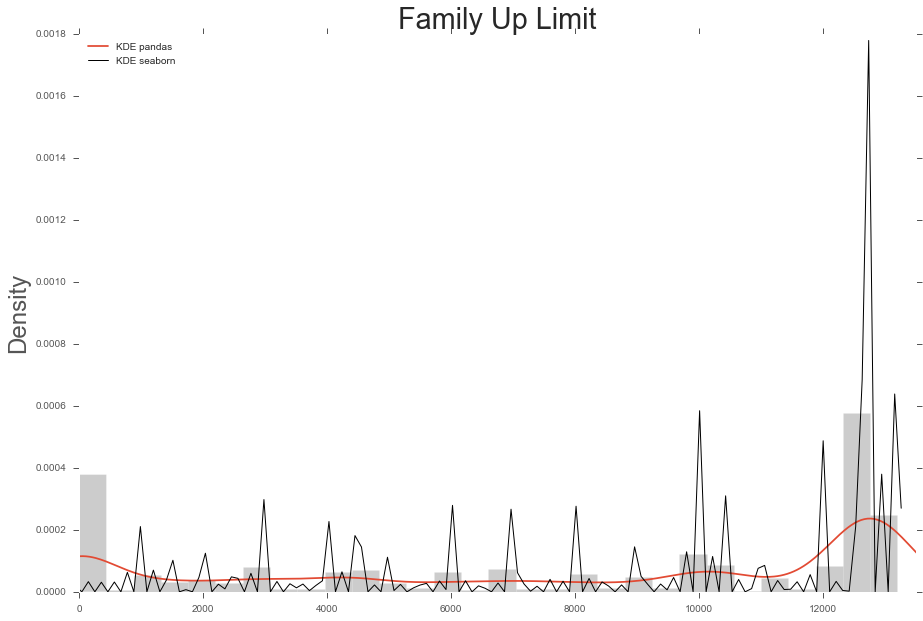

In [39]:
fig, ax = plt.subplots(figsize=(15,10))
PlanAttributesData_3.Family_Up_Limit.hist(bins=30, normed=True, alpha=0.4, color='grey')
PlanAttributesData_3.Family_Up_Limit.plot(kind='kde', title='Family Up Limit', label='KDE pandas')
sns.kdeplot(PlanAttributesData_3.Family_Up_Limit, bw=20, color='black', lw=1.0, label='KDE seaborn')
plt.xlim([0,13500])

#### As the KDE chart shows, lots of plan limits are 0, that means these plans are for the poor people who need help. And we can find that most limits are more than 12000, that means the U.S. insurance issurers like focusing on high-end plan products. Maybe that's why Americans usually spend loads of money on their health insurance.
#### The eye is much better at judging distances than areas, so we can find the the result easily by the CDF line's trend:

(0, 13500)

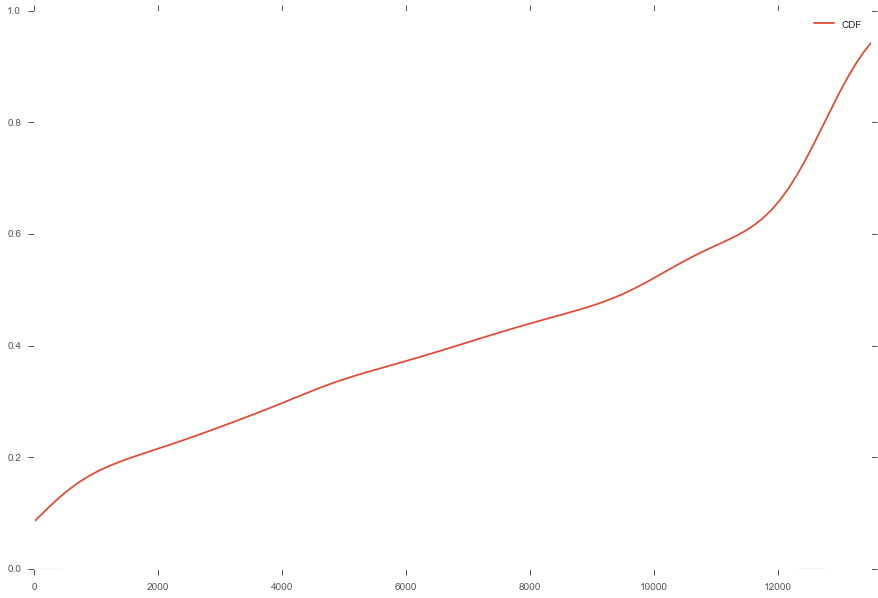

In [40]:
sns.kdeplot(PlanAttributesData_3.Family_Up_Limit, cumulative=True, label='CDF')
PlanAttributesData_3.Family_Up_Limit.hist(bins=30, normed=True, alpha=0.2, color='grey')
plt.xlim([0,13500])

#### What's the out-of-package limit trend by year? Is't cheaper, more expansive or stable? Let's check it by the "ImportDate" feature:

In [41]:
date_object1 = pd.to_datetime(PlanAttributesData_1['ImportDate'])
PlanAttributesData_1['weekday'] = date_object1.dt.dayofweek
PlanAttributesData_1['month'] = date_object1.dt.month
PlanAttributesData_1['year'] = date_object1.dt.year
PlanAttributesData_1['hour'] = date_object1.dt.hour
PlanAttributesData_1['minute'] = date_object1.dt.minute
PlanAttributesData_1['second'] = date_object1.dt.second

#### Now we use "groupby" to get the median values by year:

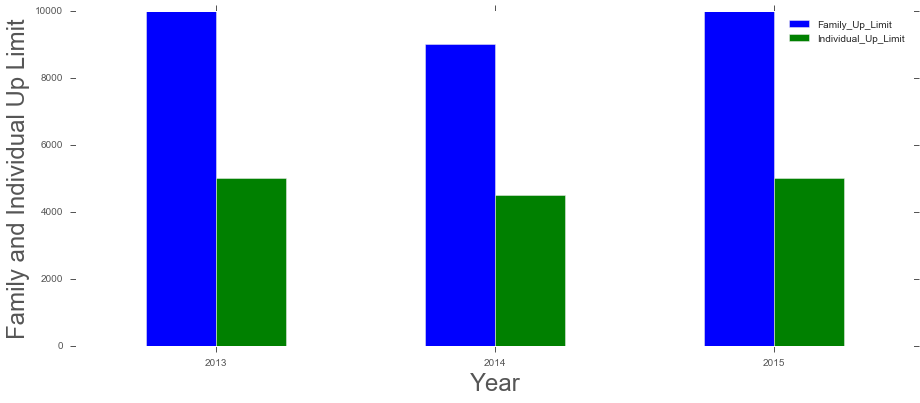

In [42]:
p = PlanAttributesData_1.groupby('year').median()[["Family_Up_Limit", "Individual_Up_Limit"]].plot(kind = 'bar', figsize = (15, 6), rot = 0)
_ = p.set_xlabel("Year"), p.set_ylabel("Family and Individual Up Limit"), p.legend(["Family_Up_Limit", "Individual_Up_Limit"])

#### Looking stable. So there is no big price fluctuation in U.S. insurance market in there three years.

### 2.2  State Rate Analysis

#### There are 50 states in America. Are the individual rates same in so many states? We can check by boxplot below:

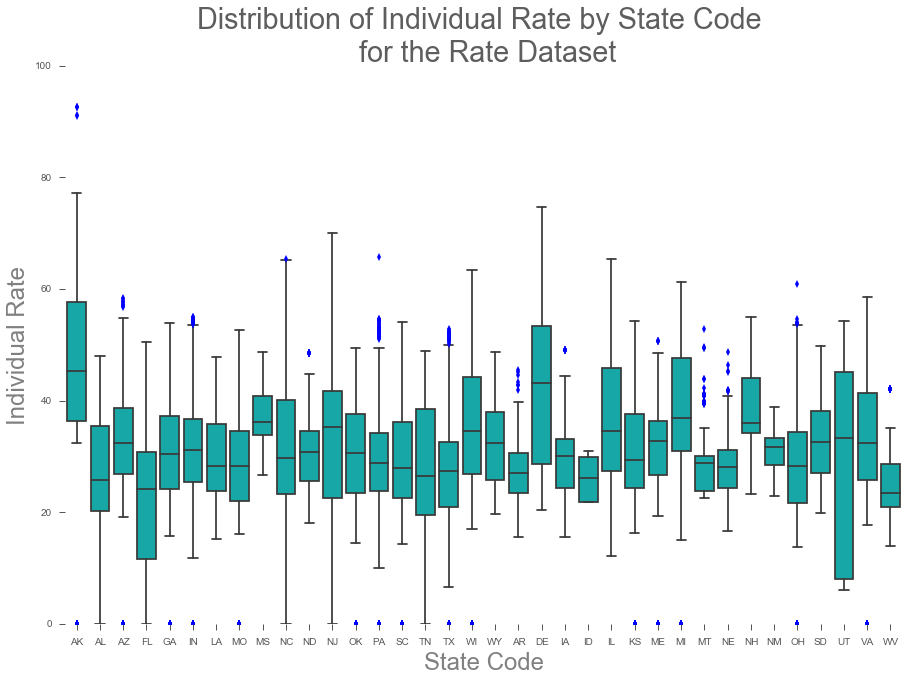

In [43]:
sns.boxplot(x="StateCode", y="IndividualRate", data=RateData_FO_3, color="c")

sns.despine(left=True, bottom=True)

plt.ylabel('Individual Rate', alpha=0.75)
plt.xlabel('State Code', alpha=0.75)
plt.title('Distribution of Individual Rate by State Code \n for the Rate Dataset', alpha=0.75)

#### There are big differences between the states. It's clear that the individual rates in DE, AK and MS are very high. Why is it so high? Do the people in these states have enough plan choices? I use "groupby" to coculate it below: 

D:\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: order is deprecated, use sort_values(...)
  from ipykernel import kernelapp as app


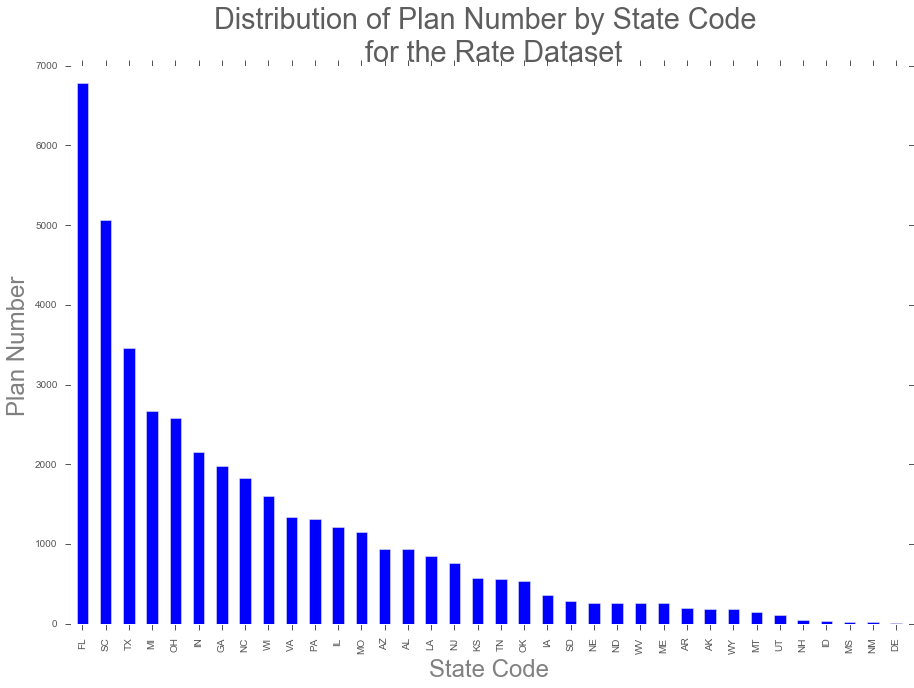

In [44]:
Plans_grouped = RateData_FO_3['PlanId'].groupby(RateData_FO_3['StateCode'])
Plans_grouped.count().order(ascending=False).plot(kind='bar')
plt.ylabel('Plan Number', alpha=0.75)
plt.xlabel('State Code', alpha=0.75)
plt.title('Distribution of Plan Number by State Code \n for the Rate Dataset', alpha=0.75)

#### The graph above shows the states where the plan offered. As It can be seen, there are fewer plan choices in DE, AK and MS states. The FL uses the plan more than the other states, so you can find the rates in this state are much cheaper. You can find why the competition is very important in the health insurance market.
----------------------

#### However besides the quantity of plans offered, we are also looking at the average rate in each state, in order to confirm if it has a better chance of having lower rate when it comes to more plan options.
Therefore we group the dataset by stateCode into mean values.

In [45]:
RateData_sub1 = RateData_FO_2.ix[:, [1,6,7,8,9,10]] # Select used data column
gr_statecode = RateData_sub1.groupby('StateCode').mean().reset_index()
gr_statecode.head(3)

,StateCode,IndividualRate,Couple,CoupleAndOneDependent,CoupleAndTwoDependents,CoupleAndThreeOrMoreDependents
0,AK,44.811828,73.486559,122.668871,138.857796,160.30000
1,AL,24.168707,39.482981,56.344541,73.207436,93.53563
2,AR,27.758827,46.289745,69.240918,92.193980,121.80352


#### Display five graphs to illustrate each rate plan by region.

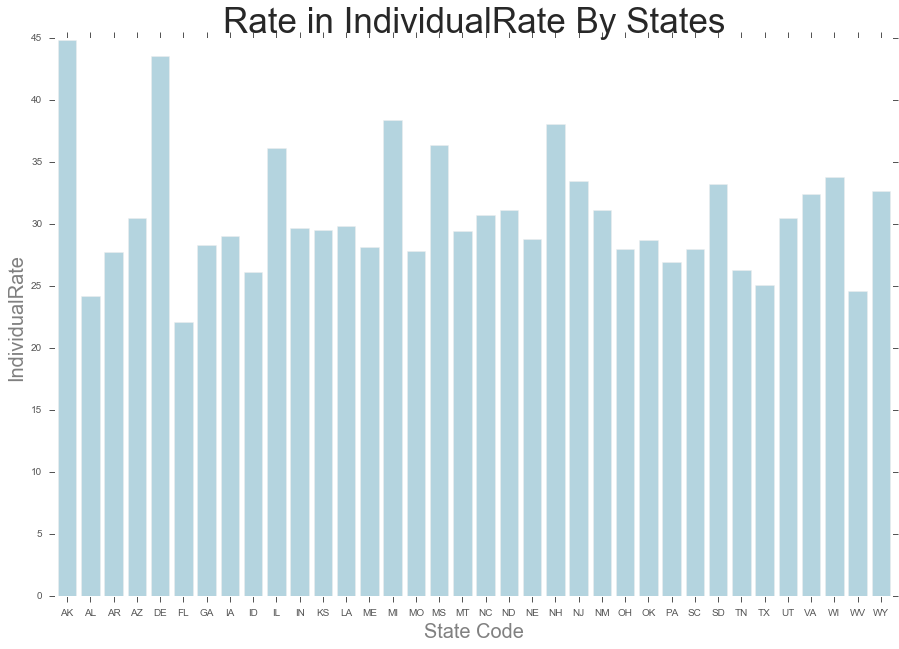

Figure: IndividualRate_By_State


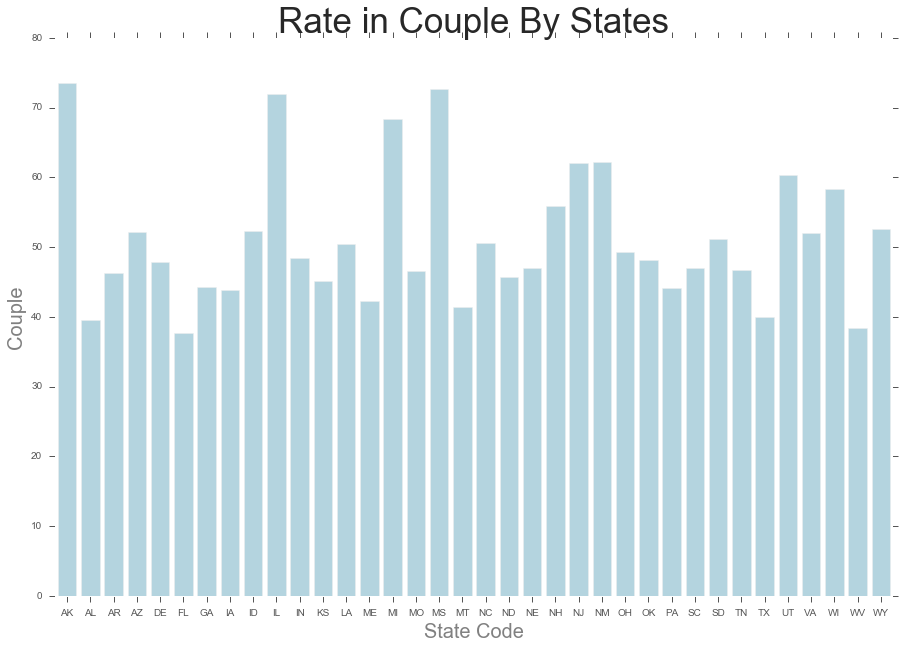

Figure: Couple_By_State


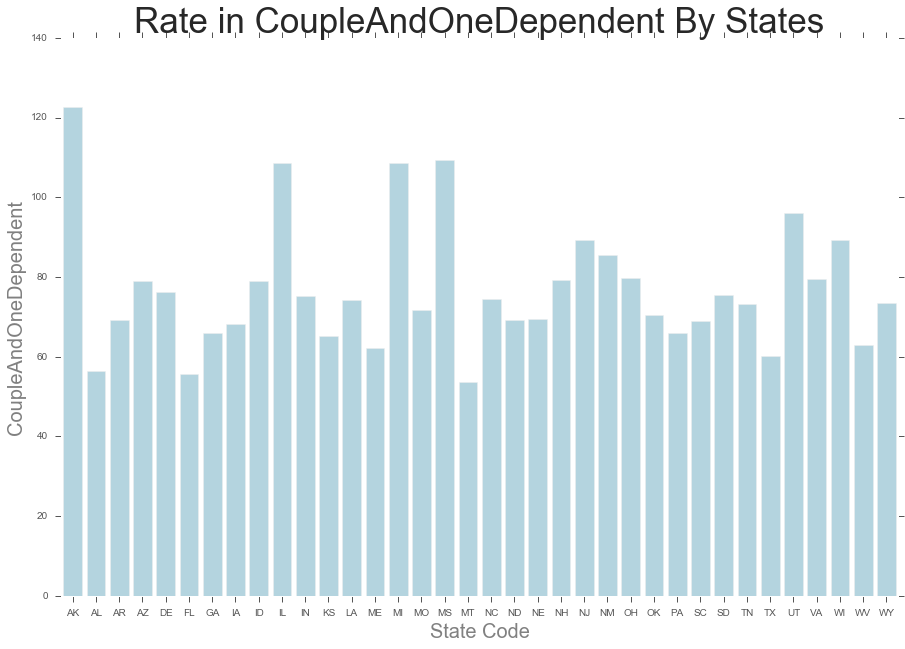

Figure: CoupleAndOneDependent_By_State


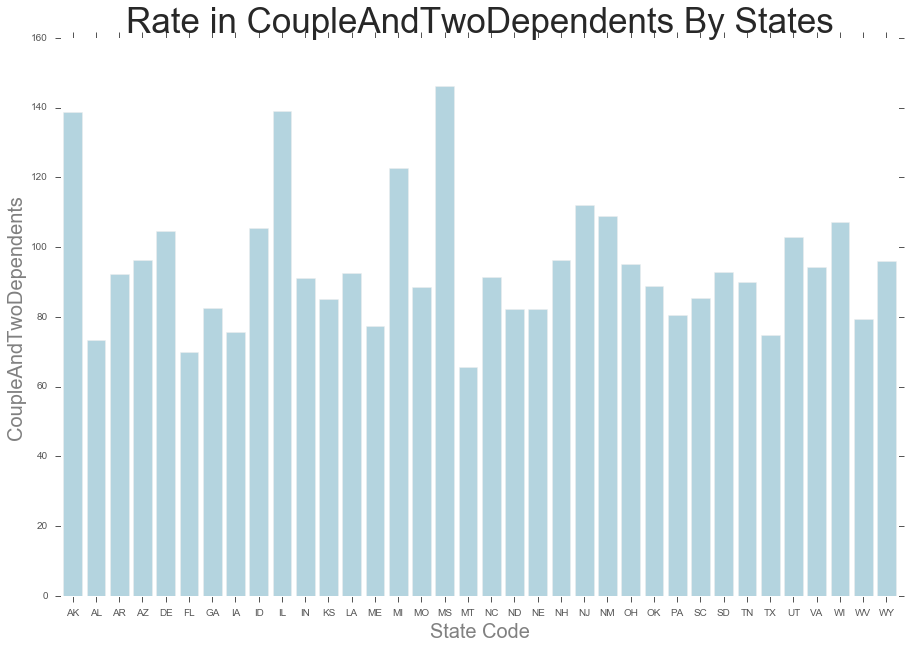

Figure: CoupleAndTwoDependents_By_State


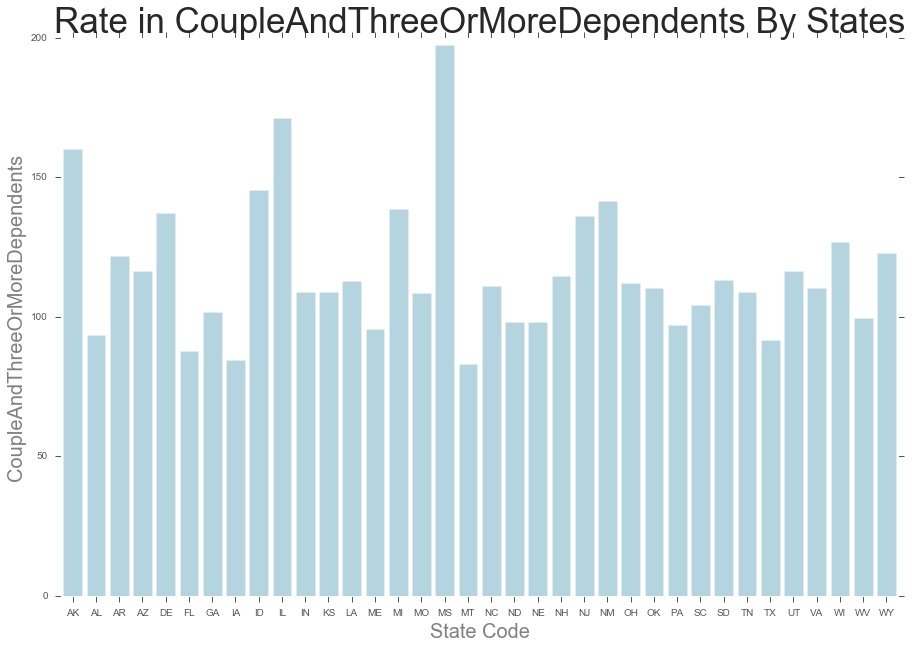

Figure: CoupleAndThreeOrMoreDependents_By_State


In [46]:
for x in gr_statecode.ix[:, 1:6].columns:
    sns.barplot(x="StateCode", y=x, data=gr_statecode, color='lightblue')
    plt.ylabel(x, alpha=0.75,fontsize=20)
    plt.xlabel('State Code', alpha=0.75, fontsize=20)
    plt.title("Rate in "+ x +" By States",fontsize=35)
    plt.show()
    print "Figure: "+ x + "_By_State"

#### Graph Summary
According to these graphs we noticed that AK, DE, MS, IL are the states with top highest average rate. AK took the 1st place in:
* <i>Figure: IndividualRate_By_State<i/> 
* <i>Figure: Couple_By_State<i/> 
* <i>Figure: CoupleAndOneDependent_By_State<i/> 

while MS also reached the peak in:
* <i>Figure: CoupleAndTwoDependents_By_State <i/> 
* <i>Figure: CoupleAndThreeOrMoreDependents_By_State<i/> 

#### These states have respectively less plan options offered as mentioned in previous analysis. However, state with huge number of plans such as FL kept very low average rate in all graphs. Thus we can determine the influence between average rate and plan quantity.
----------------------------

#### Now we will calculate the median values for the rates in each states:

In [47]:
StateMedRate = RateData_FO_3.groupby('StateCode').median()
StateMedRate = StateMedRate.drop(StateMedRate[[0,1]],1)
StateMedRate.head(3)

,IndividualRate,Couple,CoupleAndOneDependent,CoupleAndTwoDependents,CoupleAndThreeOrMoreDependents
StateCode,,,,,
AK,45.39,78.730,132.705,154.925,160.49
AL,25.70,37.985,58.445,77.865,105.05
AR,27.02,49.465,75.230,98.720,128.11


#### And we can find the relationship between the Individual Rate and family rates:

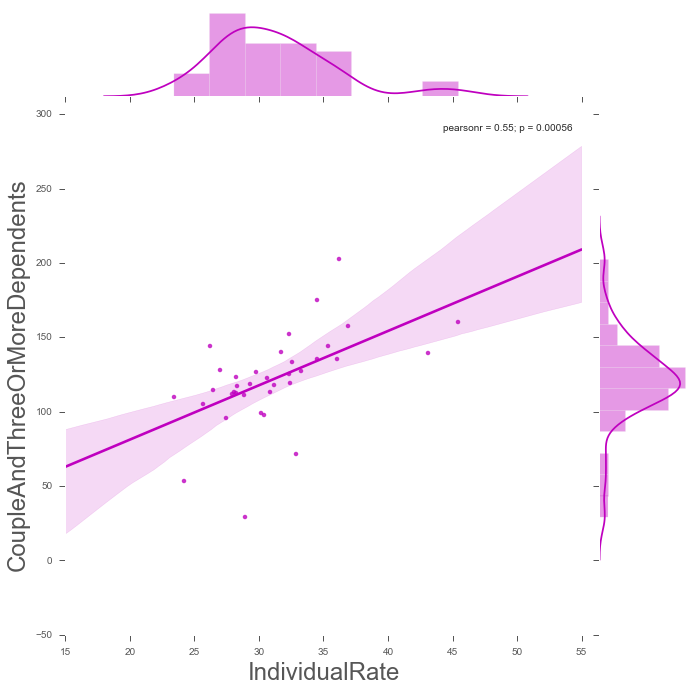

In [48]:
plt = sns.jointplot("IndividualRate", "CoupleAndThreeOrMoreDependents", data=StateMedRate, kind="reg", color="m", size=10)
sns.plt.show()

#### As can be seen from the chart above, most individual rates are around 30 and most family rates are between 100 and 150, that means health insurance is still big expense for the American parents. You can find the same result from another angle:

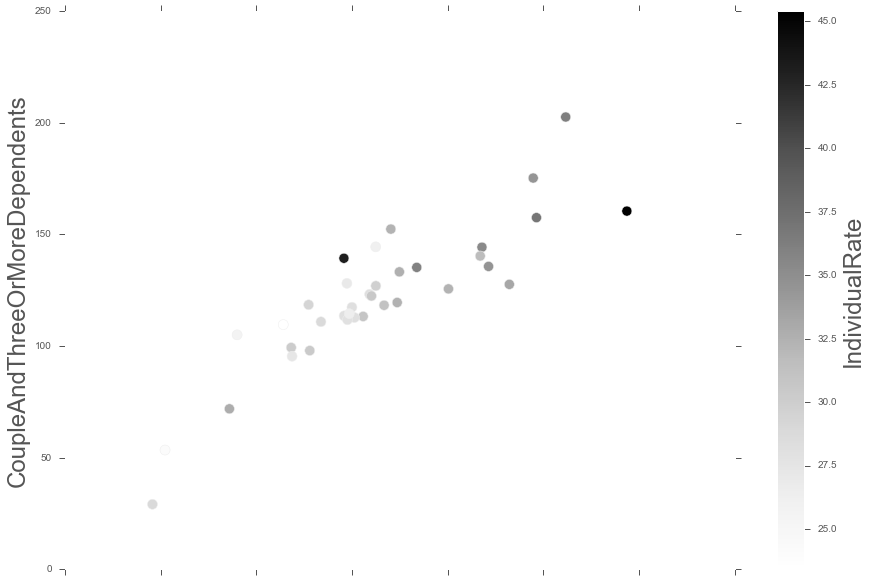

In [49]:
StateMedRate.plot(kind='scatter', x='Couple', y='CoupleAndThreeOrMoreDependents', c='IndividualRate', s=100);

#### Then we can also focus on the individual rates for the whole market:

(0, 70)

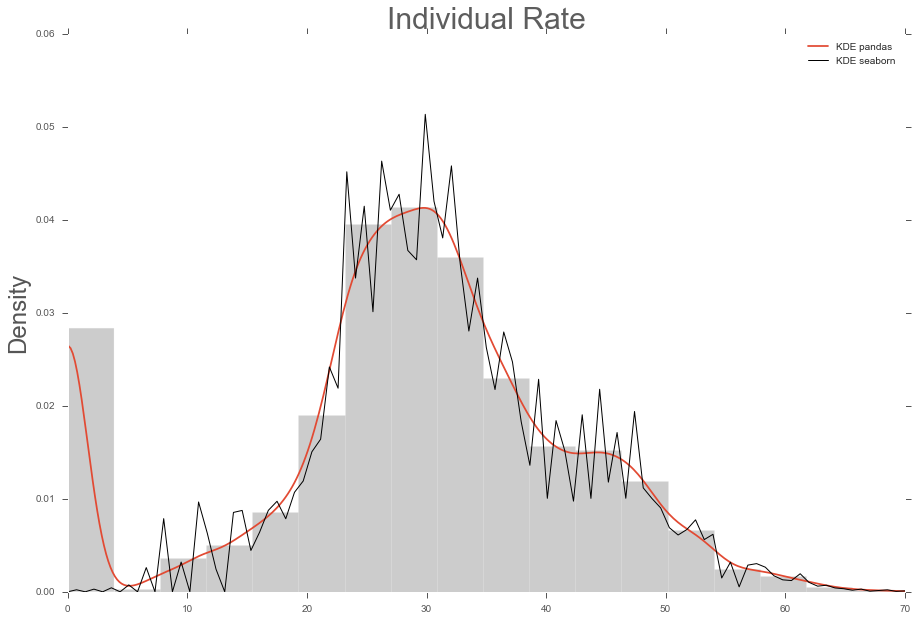

In [50]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,10))
RateData_FO_1.IndividualRate.hist(bins=24, normed=True, alpha=0.4, color='grey')
RateData_FO_1.IndividualRate.plot(kind='kde', title='Individual Rate', label='KDE pandas')
sns.kdeplot(RateData_FO_1.IndividualRate, bw=0.001, color='black', lw=1.0, label='KDE seaborn')
plt.title('Individual Rate', alpha=0.75, fontsize=30)
plt.xlim([0,70])

#### It's clear that most individual rates are around 30. Of course there are still some 0 dollar plans for the poor people. And we can find the trend clearly by CDF:

(0, 70)

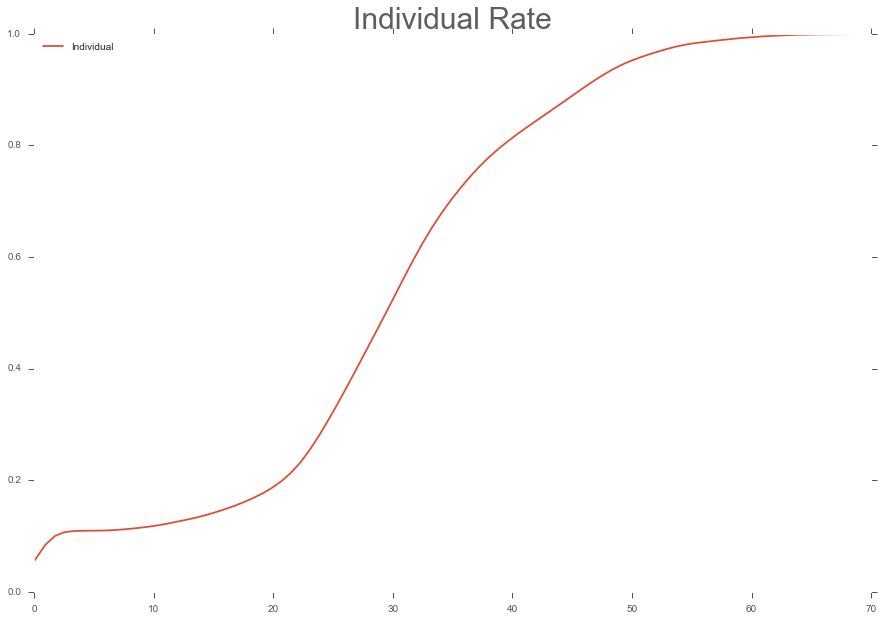

In [51]:
fig, ax = plt.subplots(figsize=(15,10))
sns.kdeplot(RateData_FO_1.IndividualRate, cumulative=True, label='Individual')
plt.title('Individual Rate', alpha=0.75, fontsize=30)
plt.xlim([0,70])

### 2.3 Year Rate Analysis

#### In this section we will focus on data distributaion on year factor. We found the data of values of '0' in rate column heavily affect resulting,(mainly data about family plans, which is simply because the issuer did not offer the plan or it was not published).Thus it is necessary to drop these invalid data.

In [52]:
#RateData_FO_2[RateData_FO_2.IndividualRate == 0].head()
RateData_droped=RateData_FO_2.drop(RateData_FO_2[RateData_FO_2.Couple == 0].index)
RateData_droped.head(5)

,BusinessYear,StateCode,IssuerId,ImportDate,PlanId,Age,IndividualRate,Couple,CoupleAndOneDependent,CoupleAndTwoDependents,CoupleAndThreeOrMoreDependents
1,2014,AK,21989,2014-03-19 07:06:49,21989AK0020001,Family Option,36.95,73.9,144.56,144.56,144.56
2,2014,AK,21989,2014-03-19 07:06:49,21989AK0020001,Family Option,36.95,73.9,144.56,144.56,144.56
5,2014,AK,21989,2014-03-19 07:06:49,21989AK0020001,Family Option,36.95,73.9,144.56,144.56,144.56
6,2014,AK,21989,2014-03-19 07:06:49,21989AK0020002,Family Option,32.45,64.9,126.95,126.95,126.95
9,2014,AK,21989,2014-03-19 07:06:49,21989AK0020002,Family Option,32.45,64.9,126.95,126.95,126.95


#### Scatter graphs based on Comparision of Individual rate and family plan rate(Take Couple And Three Or More Dependents on behalf).

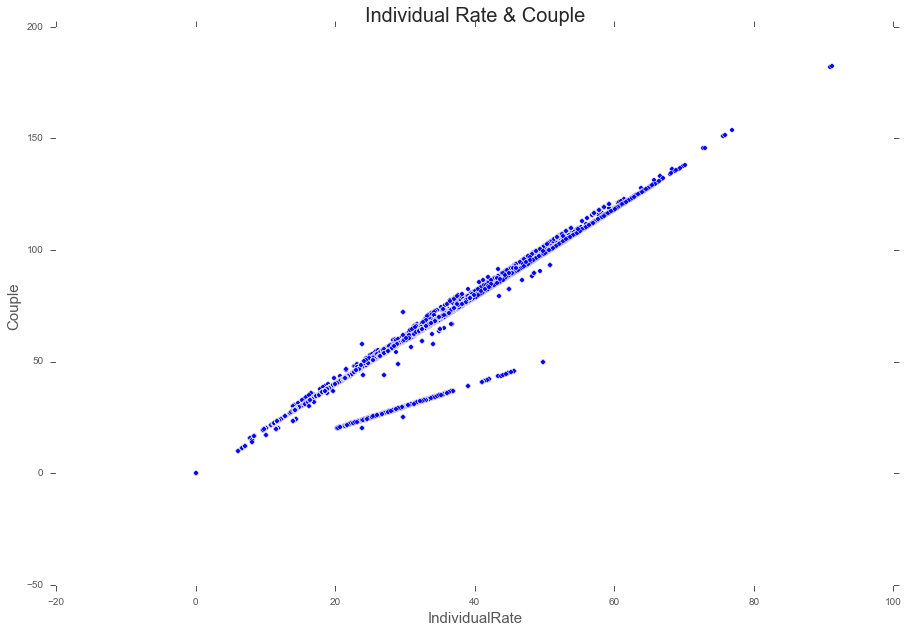

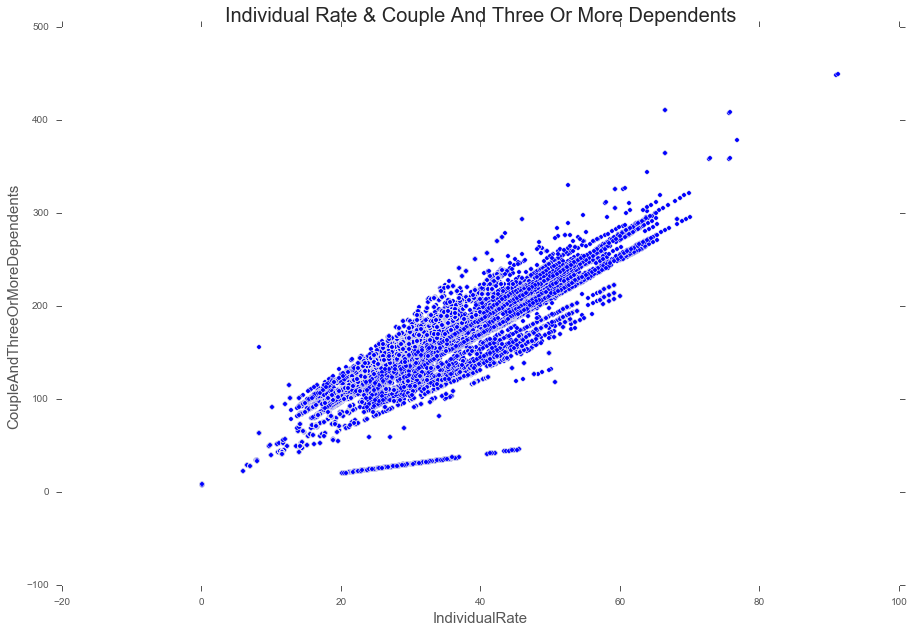

In [53]:
plt.scatter(RateData_droped.IndividualRate, RateData_droped.Couple)
plt.ylabel('Couple',fontsize=15)
plt.xlabel('IndividualRate',fontsize=15)
plt.title("Individual Rate & Couple", fontsize=20)
plt.show()

plt.scatter(RateData_droped.IndividualRate, RateData_droped.CoupleAndThreeOrMoreDependents)
plt.ylabel('CoupleAndThreeOrMoreDependents',fontsize=15)
plt.xlabel('IndividualRate',fontsize=15)
plt.title("Individual Rate & Couple And Three Or More Dependents", fontsize=20)
plt.show()

#### When we tried to find the relationship between individual rate and other methods of rate, we found that the distributions are pretty fixed and seems to form multiple lines from above graphs. This is because it was not grouped and many duplicated data are produced. However we will generate multiple graphs in details.

-----------

#### Grouping year
#### So can we find information according to business year and area facts? eg. which year has the lowest rate in specific state? <br/>
To display more details, we will consider area fact(StateCode) also.

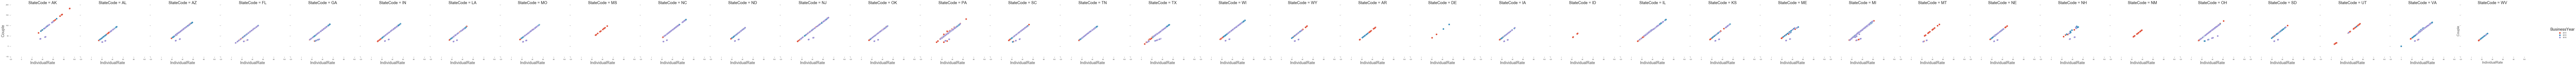

In [54]:
g = sns.FacetGrid(RateData_droped, col="StateCode",  hue="BusinessYear", size=6)
g.map(plt.scatter, "IndividualRate", "Couple", s=100, edgecolor="w").add_legend()
plt.ylabel('Couple',fontsize=20)
plt.xlabel('IndividualRate',fontsize=20)
#plt.title("Individual Rate & Couple", fontsize=20)

*** Figure Rate_1: Individual Rate & Couple ***

--------------

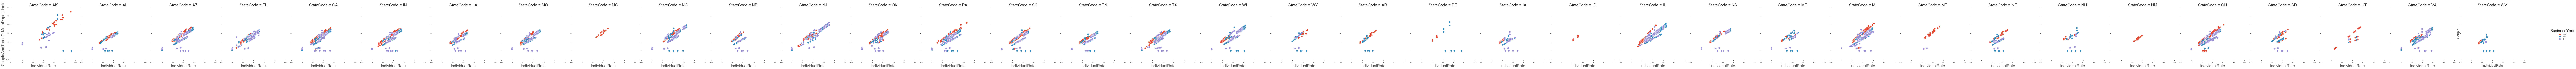

In [55]:
g = sns.FacetGrid(RateData_FO_2, col="StateCode",  hue="BusinessYear", size=6)
g.map(plt.scatter, "IndividualRate", "CoupleAndThreeOrMoreDependents", s=100, edgecolor="w").add_legend()
plt.ylabel('Couple',fontsize=20)
plt.xlabel('IndividualRate',fontsize=20)

*** Figure Rate_2: Individual Rate & Couple And Three Or More Dependents ***

--------------

### Summary
Above charts showed the relationship between Individual Rate and other attributes more clearly. We can answer the question asked previously. <br/>For example, from the one in Rate_2 where stateCode=AK, we would know year 2016 has the lowest rate of Couple-And-Three-Or-More-Dependents, and 2014 has the lowest individual rate in Alaska(AK). And this trend seems to apply to most states.

## 3. Predictive Modelling

### 3.1 Predict Family Plan Rate by Individual Rate (Regression)

We want to build a regression model to predict an approximate rate by somehow. For example, given the individual rate, can we predict the couple rate for the policy? Assume issuer and state information are unknown, we can simply generate an OLS regression model for prediction.

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     CoupleAndOneDependent   R-squared:                       0.560
Model:                               OLS   Adj. R-squared:                  0.560
Method:                    Least Squares   F-statistic:                 4.417e+04
Date:                   Mon, 30 May 2016   Prob (F-statistic):               0.00
Time:                           10:49:04   Log-Likelihood:            -1.6408e+05
No. Observations:                  34639   AIC:                         3.282e+05
Df Residuals:                      34637   BIC:                         3.282e+05
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept        -13.2164      0.491    -26.893      0.000       -14.180   -12.253
IndividualRate     3.1113      0.015    210.171      0.000         3.082     3.140
==============================================================================
Omnibus:                     3157.738   Durbin-Watson:                   0.063
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4097.218
Skew:                          -0.840   Prob(JB):                         0.00
Kurtosis:                       2.869   Cond. No.                         110.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

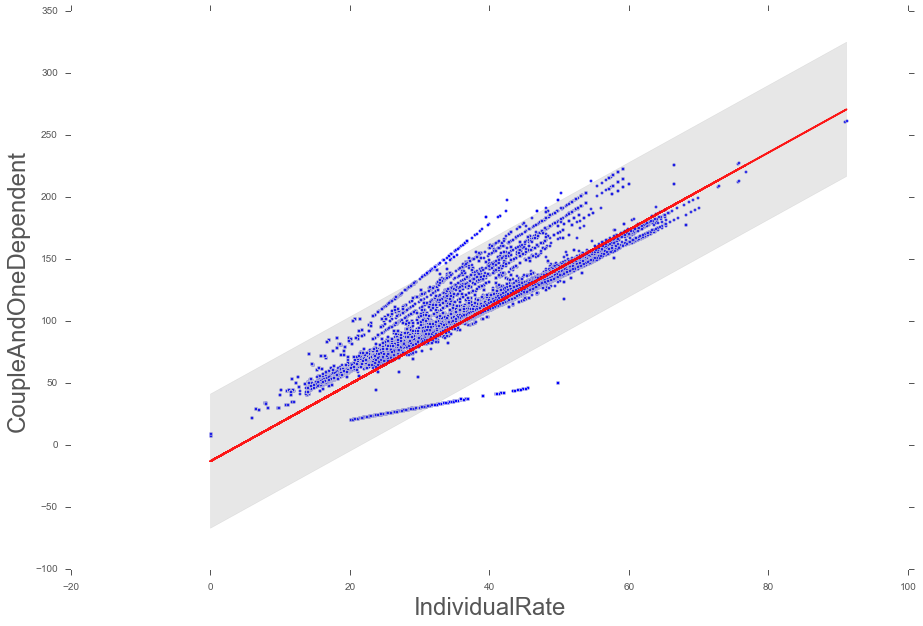

In [56]:
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

#generate the model
mod = smf.ols(formula='CoupleAndOneDependent ~ 1 + IndividualRate', data=RateData_droped.dropna()).fit()

#extract the parameters for the confidence window
x_pred = np.linspace(RateData_droped.IndividualRate.min(), RateData_droped.IndividualRate.max(), len(RateData_droped.IndividualRate))
x_pred2 = sm.add_constant(x_pred)

#confidence = 95% (alpha=0.05)
sdev, lower, upper = wls_prediction_std(mod, exog=x_pred2, alpha=0.05)

#plot points and confidence window
plt.scatter(RateData_droped.IndividualRate, RateData_droped.CoupleAndOneDependent, s=10, alpha=0.9)
plt.fill_between(x_pred, lower, upper, color='#888888', alpha=0.2)

#plot the regression line
plt.plot(RateData_droped.IndividualRate.dropna(), mod.predict(RateData_droped[['IndividualRate']] ), 'b-', label='Linear n=1 $R^2$=%.2f' % mod.rsquared, alpha=0.9, color='red')

plt.xlabel('IndividualRate')
plt.ylabel('CoupleAndOneDependent')
mod.summary()

#### Test result
Test Couple And One Dependent rate when an individual rate is known as 85. Note the result is not accurate but it gives an approximate rate though all states and issuers.

In [57]:
predictor = 85
result_reg=mod.predict(pd.Series(data={'IndividualRate':predictor}))
print "Predicted rate of Couple-and-one-dependent is "+ str(result_reg[0]) + " when individual rate is " + str(predictor)

Predicted rate of Couple-and-one-dependent is 251.242526606 when individual rate is 85


---

#### Now we will predict other family plans' rate, making Couple as predictor. We define a confidence interval to see where the true model parameters lies.

In [58]:
import scipy

def linregress_CIs(xd,yd,conf=0.95):
    """Linear regression CIs FTW!"""
    alpha=1.-conf   # significance
    n = xd.size   # data sample size
    x = np.linspace(xd.min(),xd.max(),1000)
        
    # Predicted values from fitted model:
    a, b, r, p, err = scipy.stats.linregress(xd,yd)
    y = a*x+b
    
    sd = 1./(n-2.)*np.sum((yd-a*xd-b)**2)
    sd = np.sqrt(sd)
    sxd = np.sum((xd-xd.mean())**2)
    sx  = (x-xd.mean())**2
    
    # quantile of student's t distribution for p=1-alpha/2
    q = scipy.stats.t.ppf(1.-alpha/2, n-2)
    
    # get the upper and lower CI:
    dy = q*sd*np.sqrt( 1./n + sx/sxd )
    yl = y-dy
    yu = y+dy
    
    return yl,yu,x

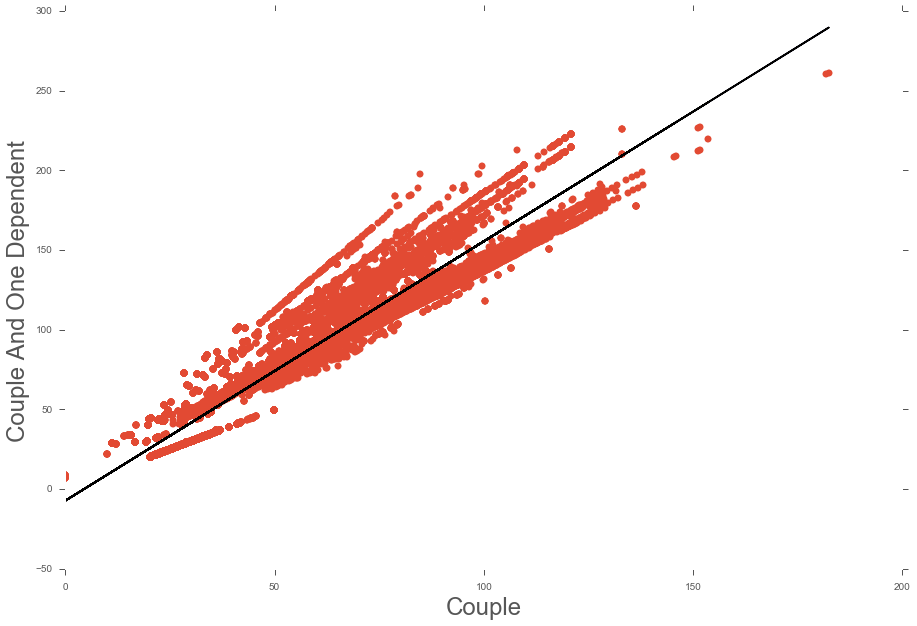

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     CoupleAndOneDependent   R-squared:                       0.910
Model:                               OLS   Adj. R-squared:                  0.910
Method:                    Least Squares   F-statistic:                 3.502e+05
Date:                   Mon, 30 May 2016   Prob (F-statistic):               0.00
Time:                           10:49:07   Log-Likelihood:            -1.3661e+05
No. Observations:                  34639   AIC:                         2.732e+05
Df Residuals:                      34637   BIC:                         2.732e+05
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -7.2548      0.170    -42.646      0.000        -7.588    -6.921
Couple         1.6267      0.003    591.805      0.000         1.621     1.632
==============================================================================
Omnibus:                     4294.654   Durbin-Watson:                   0.109
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6296.680
Skew:                           0.930   Prob(JB):                         0.00
Kurtosis:                       3.951   Cond. No.                         157.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [59]:
yl,yu,xd = linregress_CIs(RateData_droped.Couple.as_matrix(),RateData_droped.CoupleAndOneDependent.as_matrix(), .95)
mod = smf.ols(formula='CoupleAndOneDependent ~ 1 + Couple', data=RateData_droped).fit()

plt.xlabel('Couple')
plt.ylabel('Couple And One Dependent')
plt.plot(RateData_droped.Couple,RateData_droped.CoupleAndOneDependent, 'o')
plt.plot(RateData_droped.Couple, mod.params[1]*RateData_droped.Couple+mod.params[0],'k-')
plt.fill_between(xd, yl, yu, alpha=0.3, facecolor='blue',edgecolor='none')
plt.show()
mod.summary()

#### The confidence interval does not seem to show up, for this case we then try Polynomial model.

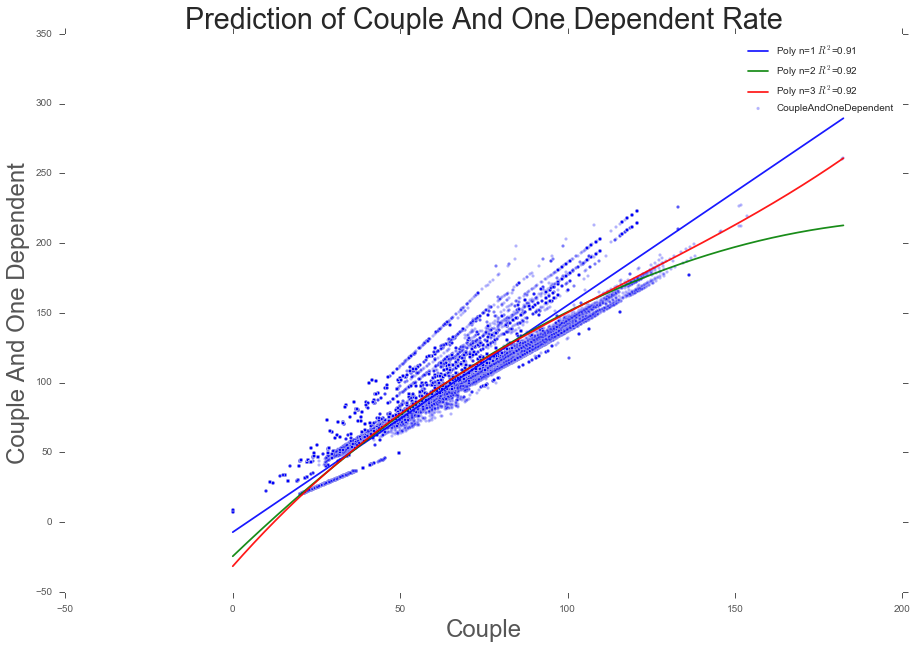

In [60]:
plt.scatter( RateData_droped.Couple, RateData_droped.CoupleAndOneDependent, s=10, alpha=0.3)
plt.xlabel('Couple')
plt.ylabel('Couple And One Dependent')
plt.title("Prediction of Couple And One Dependent Rate")

# points linearlyd space on lstats
x = pd.DataFrame({'Couple': np.linspace(RateData_droped.Couple.min(), RateData_droped.Couple.max(), len(RateData_droped.Couple)) })

# 1-st order polynomial
poly_1 = smf.ols(formula='CoupleAndOneDependent ~ 1 + Couple', data=RateData_droped).fit()
plt.plot(x, poly_1.predict(x), 'b-', label='Poly n=1 $R^2$=%.2f' % poly_1.rsquared,  alpha=0.9)

# 2-nd order polynomial
poly_2 = smf.ols(formula='CoupleAndOneDependent ~ 1 + Couple + I(Couple ** 2.0)', data=RateData_droped).fit()
plt.plot(x, poly_2.predict(x), 'g-', label='Poly n=2 $R^2$=%.2f' % poly_2.rsquared, alpha=0.9)

# 3-rd order polynomial
poly_3 = smf.ols(formula='CoupleAndOneDependent ~ 1 + Couple + I(Couple ** 2.0) + I(Couple ** 3.0)', data=RateData_droped).fit()
plt.plot(x, poly_3.predict(x), 'r-', alpha=0.9,
         label='Poly n=3 $R^2$=%.2f' % poly_3.rsquared)

plt.legend()
#poly_1.mse_resid


#### Test all three lines to compare their predicting result.

In [61]:
result_poly=poly_1.predict(pd.Series(data={'Couple':150}))
print result_poly
result_poly=poly_2.predict(pd.Series(data={'Couple':150}))
print result_poly
result_poly=poly_3.predict(pd.Series(data={'Couple':150}))
print result_poly

[ 236.75552494]
[ 197.15766754]
[ 212.97454938]


#### The curved predicting lines have a decreasing trend compare to when it's set n=1. Though the result we find poly n=2 is the best fit line as data are concentrated a bit lower than poly n=1.
-----

### 3.2 Predict Month by BusinessYear and Individual Rate (kNN)

#### Different target costomer plans are issued at different time. Can we predict which month should the plan be issued in the fixed business year? Yes, we can use kNN to make it.
#### First, get the 'month' column:

In [62]:
date_object = pd.to_datetime(RateData_FO_1['ImportDate'])
RateData_FO_1['month'] = date_object1.dt.month

In [63]:
RateData_FO_1.month.unique()

array([ nan,   4.,   3.,   7.,   1.,  11.,  10.,   9.])

#### Clean the Nan:

In [64]:
RateData_FO_1['month']=RateData_FO_1['month'].fillna(0)

#### Then map the month:

In [65]:
mapping = {1:'January', 3:'March', 4:'April' ,7:'July', 9:'September', 10:'October', 11:'November'}
RateData_FO_1['month'] = RateData_FO_1.month.map(mapping)
RateData_FO_1.head(3)

,BusinessYear,StateCode,IssuerId,ImportDate,PlanId,Age,IndividualRate,Couple,CoupleAndOneDependent,CoupleAndTwoDependents,CoupleAndThreeOrMoreDependents,month
1,2014,AK,21989,2014-03-19 07:06:49,21989AK0020001,Family Option,36.95,73.9,144.56,144.56,144.56,NaN
2,2014,AK,21989,2014-03-19 07:06:49,21989AK0020001,Family Option,36.95,73.9,144.56,144.56,144.56,NaN
5,2014,AK,21989,2014-03-19 07:06:49,21989AK0020001,Family Option,36.95,73.9,144.56,144.56,144.56,NaN


In [66]:
RateData_FO_1['month']=RateData_FO_1['month'].fillna(0)
RateData_FO_1_p1=RateData_FO_1.drop(RateData_FO_1[RateData_FO_1['month']== 0 ].index)

#### We selected IndividualRate and BusinessYear as predictors and Month as target/response variable. Then I started testing  the dataset with classification algorithm of KNN . After that I will evaluate the acuracy to see which one is the best. 

In [67]:
X = RateData_FO_1_p1[[0,6]]
y = RateData_FO_1_p1.month

In [68]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.4)

print X_train.shape
print X_test.shape

print y_train.shape
print y_test.shape

(106, 2)
(72, 2)
(106L,)
(72L,)


In [69]:
from sklearn.neighbors import KNeighborsClassifier

# Look at the two closest neighbors.
knn = KNeighborsClassifier(n_neighbors=4, metric='euclidean')

In [70]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_neighbors=4, p=2, weights='uniform')

In [71]:
# Make point predictions on the test set using the fit model.
y_pred = knn.predict(X_test)
y_pred

array(['September', 'March', 'March', 'January', 'January', 'September',
       'January', 'March', 'September', 'January', 'March', 'March',
       'March', 'March', 'January', 'March', 'January', 'July', 'January',
       'March', 'March', 'March', 'March', 'March', 'March', 'September',
       'March', 'March', 'March', 'January', 'March', 'January', 'January',
       'March', 'March', 'March', 'March', 'March', 'March', 'January',
       'March', 'March', 'January', 'March', 'March', 'March', 'March',
       'July', 'March', 'March', 'January', 'January', 'January', 'March',
       'March', 'January', 'March', 'March', 'January', 'March', 'March',
       'March', 'September', 'March', 'January', 'March', 'March', 'March',
       'March', 'July', 'September', 'January'], dtype=object)

In [72]:
knn.score(X_test, y_test)

0.47222222222222221

In [73]:
from sklearn import metrics
print metrics.classification_report(y_test, y_pred)

             precision    recall  f1-score   support

    January       0.21      0.29      0.24        14
       July       1.00      0.30      0.46        10
      March       0.57      0.81      0.67        31
   November       0.00      0.00      0.00         1
    October       0.00      0.00      0.00         3
  September       0.33      0.15      0.21        13

avg / total       0.48      0.47      0.44        72



D:\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\sklearn\metrics\classification.py:958: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### the model predict better on March with 0.67 accuracy. However, it predicts worse on November and October

### 3.3 Predict the Couple Rate by Individual Rate (kNN)

#### Is there any clue linking the different Rates? We can try to find it by kNN. Now we predict the couple rate depend on Individual Rate:

In [74]:
X = StateMedRate.IndividualRate.values
X = np.reshape(X, (len(StateMedRate.IndividualRate), 1))
y = StateMedRate.Couple.values
y = np.reshape(y, (len(StateMedRate.Couple), 1))

print X.shape     
print y.shape  

(36L, 1L)
(36L, 1L)


#### First we try k=5:

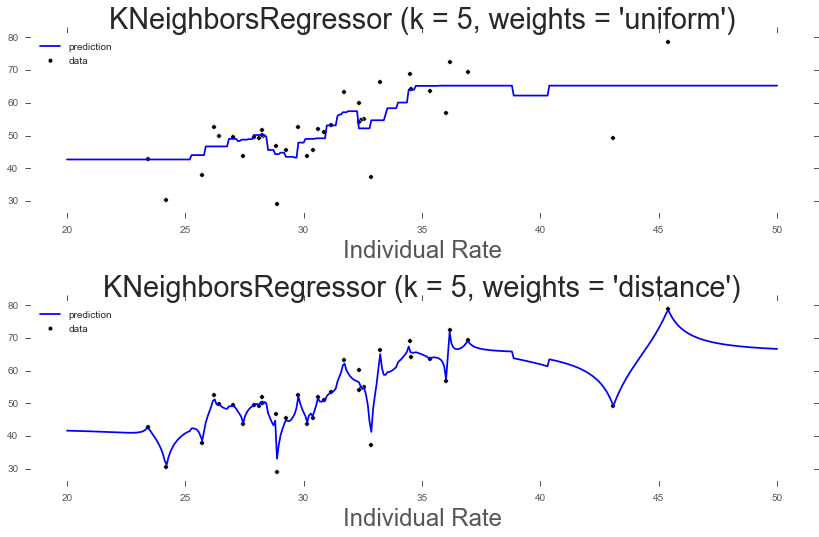

In [75]:
from sklearn import neighbors
rcParams['figure.figsize'] = 14, 8

x = np.linspace(20, 50, 400)[:, np.newaxis]
n_neighbors=5

for i, weights in enumerate(['uniform', 'distance']):
    knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
    yp = knn.fit(X, y).predict(x)
    
    plt.subplot(2, 1, i + 1)
    plt.scatter(X, y, c='k', label='data')
    plt.plot(x, yp, c='b', label='prediction')
    plt.axis('tight')
    plt.xlabel('Individual Rate')
    plt.legend(loc='upper left')
    plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors, weights))
    plt.subplots_adjust( hspace=0.5)
    
plt.show()

#### Now we get the prediction about the Couple value. In this model I make k=5, but is it a good value for k? We need to coculate the best value for our prediction. First we will train the model and create the predicted values:

In [76]:
from sklearn import neighbors
knn = neighbors.KNeighborsRegressor(n_neighbors=5, weights='uniform')
mod = knn.fit(X, y)

In [77]:
x = np.reshape(StateMedRate.IndividualRate.values, (len(StateMedRate.IndividualRate), 1)) + 0.001
y_hat = mod.predict(x)

#### Make a definition to calculate the r square and rmse:

In [78]:
def calculate_regression_goodness_of_fit(ys, y_hat):
    ss_total = 0
    ss_residual = 0
    ss_regression = 0
    y_mean = y.mean()
    
    for i in range(len(ys)):
        ss_total += np.square(ys[i] - y_mean)
        ss_residual += np.square(ys[i] - y_hat[i])
        ss_regression += np.square(y_hat[i] - y_mean)
    
    r_square = ss_regression / ss_total
    rmse = np.sqrt( ss_residual / float(len(ys)) )
    
    return r_square[0], rmse[0]

In [79]:
calculate_regression_goodness_of_fit(y, yp)

(1.0644539669122659, 15.561268876129294)

#### Use loop to calculate the arrays:

In [80]:
rsquare_arr = []
rmse_arr = []

for k in range(2, len(y)):
    knn = neighbors.KNeighborsRegressor(n_neighbors=k)
    y_hat = knn.fit(X, y).predict(x)
    rsquare, rmse = calculate_regression_goodness_of_fit(y, y_hat)
    rmse_arr.append(rmse)
    rsquare_arr.append(rsquare)

#### We can plot now:

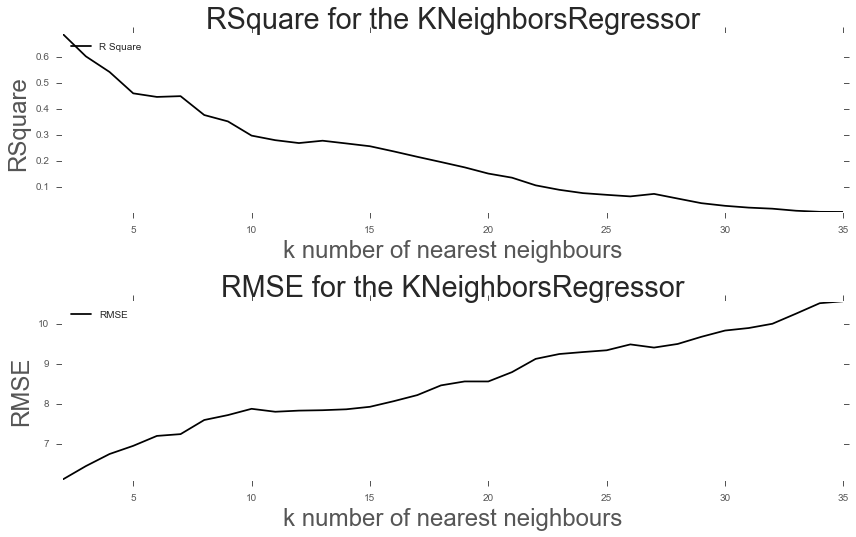

In [81]:
plt.subplot(2, 1, 1)
plt.plot(range(2, 36), rsquare_arr, c='k', label='R Square')
plt.axis('tight')
plt.xlabel('k number of nearest neighbours')
plt.ylabel('RSquare')
plt.legend(loc='upper left')
plt.title("RSquare for the KNeighborsRegressor")
plt.subplots_adjust( hspace=0.5)

plt.subplot(2, 1, 2)
plt.plot(range(2, 36), rmse_arr, c='k', label='RMSE')
plt.axis('tight')
plt.xlabel('k number of nearest neighbours')
plt.ylabel('RMSE')
plt.legend(loc='upper left')
plt.title("RMSE for the KNeighborsRegressor")

#### It's clear that 2 is the best value for k from the above plots. Now we can use it for the predictive model:

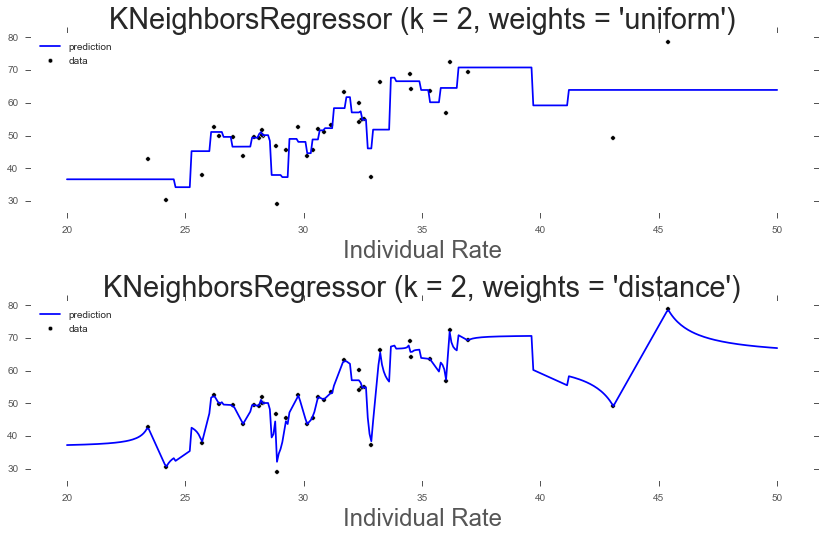

In [82]:
from sklearn import neighbors
rcParams['figure.figsize'] = 14, 8

x = np.linspace(20, 50, 400)[:, np.newaxis]
n_neighbors=2

for i, weights in enumerate(['uniform', 'distance']):
    knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
    yp = knn.fit(X, y).predict(x)
    
    plt.subplot(2, 1, i + 1)
    plt.scatter(X, y, c='k', label='data')
    plt.plot(x, yp, c='b', label='prediction')
    plt.axis('tight')
    plt.xlabel('Individual Rate')
    plt.legend(loc='upper left')
    plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors, weights))
    plt.subplots_adjust( hspace=0.5)
    
plt.show()

#### Now we get the clue linking the Individual Rates and the Couple Rates.

### 3.4 Predict State by Rates (Classification)

#### The rates of plans are different for different State. If we have a plan with five rates, can we predict which state is it most probably for? No problem, we can make it by Python.
#### First, import GaussianNB:

In [83]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()

In [84]:
RateData_FO_3.head(3)

,BusinessYear,StateCode,IssuerId,ImportDate,PlanId,Age,IndividualRate,Couple,CoupleAndOneDependent,CoupleAndTwoDependents,CoupleAndThreeOrMoreDependents,month
1,2014,AK,21989,2014-03-19 07:06:49,21989AK0020001,Family Option,36.95,73.9,144.56,144.56,144.56,0
2,2014,AK,21989,2014-03-19 07:06:49,21989AK0020001,Family Option,36.95,73.9,144.56,144.56,144.56,0
5,2014,AK,21989,2014-03-19 07:06:49,21989AK0020001,Family Option,36.95,73.9,144.56,144.56,144.56,0


#### We can train a Naive Bayes classifier on all our training data as follows and use the model for prediction:

In [85]:
classifier = nb.fit(RateData_FO_3[['IndividualRate', 'Couple', 'CoupleAndOneDependent', 'CoupleAndTwoDependents', 
                        'CoupleAndThreeOrMoreDependents']], RateData_FO_3['StateCode'])
classifier

GaussianNB()

#### We can find out how well our classifier learned the training dataset based on overall accuracy:

In [86]:
classifier.score(RateData_FO_3[['IndividualRate', 'Couple', 'CoupleAndOneDependent', 'CoupleAndTwoDependents', 
                        'CoupleAndThreeOrMoreDependents']], RateData_FO_3['StateCode'])

0.15082679954080261

#### Now we can use the classifier to classifier the state samples. First, the median rate values of the best state FL:

In [87]:
StateMedRate.ix['FL', :5]

IndividualRate                    24.19
Couple                            30.45
CoupleAndOneDependent             46.36
CoupleAndTwoDependents            49.75
CoupleAndThreeOrMoreDependents    53.44
Name: FL, dtype: float64

In [88]:
StateMedRate['Predicted State']=''
StateMedRate.ix['FL', 'Predicted State']=classifier.predict([StateMedRate.ix['FL','IndividualRate'], 
                                                              StateMedRate.ix['FL','Couple'], 
                                                              StateMedRate.ix['FL','CoupleAndOneDependent'], 
                                                              StateMedRate.ix['FL','CoupleAndTwoDependents'], 
                                                              StateMedRate.ix['FL','CoupleAndThreeOrMoreDependents']])[0]
print "This plan should be for", StateMedRate.ix['FL', 'Predicted State'], "State!"

This plan should be for FL State!


#### Good! We get the "FL" result. Then we can try the worst state NM:

In [89]:
StateMedRate.ix['NM', :5]

IndividualRate                       31.7
Couple                               63.4
CoupleAndOneDependent               86.31
CoupleAndTwoDependents             108.41
CoupleAndThreeOrMoreDependents    140.375
Name: NM, dtype: object

In [90]:
StateMedRate.ix['NM', 'Predicted State']=classifier.predict([StateMedRate.ix['NM','IndividualRate'], 
                                                              StateMedRate.ix['NM','Couple'], 
                                                              StateMedRate.ix['NM','CoupleAndOneDependent'], 
                                                              StateMedRate.ix['NM','CoupleAndTwoDependents'], 
                                                              StateMedRate.ix['NM','CoupleAndThreeOrMoreDependents']])[0]
print "This plan should be for", StateMedRate.ix['NM', 'Predicted State'], "State!"

This plan should be for NM State!


#### The result is "NM"! So our Predictive model is good.

## 4. Unsupervised Learning

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import math 
import mpld3
from sklearn import preprocessing
from sklearn import neighbors

%matplotlib inline

### 4.1 Predict State by Rates (Clustering with k-Means)

#### We can also use clustering to predict the State by rates:

In [92]:
RateData_FO_3.head(3)

,BusinessYear,StateCode,IssuerId,ImportDate,PlanId,Age,IndividualRate,Couple,CoupleAndOneDependent,CoupleAndTwoDependents,CoupleAndThreeOrMoreDependents,month
1,2014,AK,21989,2014-03-19 07:06:49,21989AK0020001,Family Option,36.95,73.9,144.56,144.56,144.56,0
2,2014,AK,21989,2014-03-19 07:06:49,21989AK0020001,Family Option,36.95,73.9,144.56,144.56,144.56,0
5,2014,AK,21989,2014-03-19 07:06:49,21989AK0020001,Family Option,36.95,73.9,144.56,144.56,144.56,0


#### import KMeans:

In [93]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

#### Because there are 50 states, we make n_clusters = 50:

In [94]:
km = KMeans(n_clusters=50, init='random')

#### Then fit:

In [95]:
km.fit(RateData_FO_3[['IndividualRate', 'Couple', 'CoupleAndOneDependent', 'CoupleAndTwoDependents', 'CoupleAndThreeOrMoreDependents']].values)

KMeans(copy_x=True, init='random', max_iter=300, n_clusters=50, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

#### Now we can get the predictions:

In [96]:
predictions = km.predict(RateData_FO_3[['IndividualRate', 'Couple', 'CoupleAndOneDependent', 'CoupleAndTwoDependents', 'CoupleAndThreeOrMoreDependents']].values)
predictions

array([ 0,  0,  0, ..., 29, 29, 29])

#### Because our computer memory is only 8G, we cannot handle the score below:

In [97]:
#from sklearn import metrics
#metrics.silhouette_score(RateData_FO_3[['IndividualRate', 'Couple', 'CoupleAndOneDependent', 'CoupleAndTwoDependents', 'CoupleAndThreeOrMoreDependents']], predictions)

### 4.2 Predict Matel Level by Rates (Clustering with k-Means)

#### There are five kind of metal level for the insurance plans. Though we don't know the exactly standard to classify them, we can use k-means to make it:

In [98]:
PlanAttributesData_1.head(3)

,BusinessYear,StateCode,IssuerId,ImportDate,PlanId,MetalLevel,Family_Up_Limit,Individual_Up_Limit,weekday,month,year,hour,minute,second
6,2014,AK,73836,2014-04-18 11:49:29,73836AK0650002-00,Bronze,12700,6350,4,4,2014,11,49,29
7,2014,AK,73836,2014-04-18 11:49:29,73836AK0680004-00,Gold,8000,4000,4,4,2014,11,49,29
8,2014,AK,73836,2014-04-18 11:49:29,73836AK0680004-01,Gold,8000,4000,4,4,2014,11,49,29


#### Five types metallevel:

In [99]:
PlanAttributesData_1.MetalLevel.unique()

array(['Bronze', 'Gold', 'Silver', 'Catastrophic', 'Platinum'], dtype=object)

#### Prepare the dataset:

In [100]:
PlanAttributesData_1_c1 = PlanAttributesData_1[[1,2,6,7]].groupby('StateCode').mean()
#PlanAttributesData_1_c1 = PlanAttributesData_1_c1.drop('StateCode')
PlanAttributesData_1_c1.head()

,IssuerId,Family_Up_Limit,Individual_Up_Limit
StateCode,,,
AK,56779.165049,8584.223301,4291.747573
AL,51594.478992,7697.058824,3848.529412
AR,65296.025078,7918.043887,3959.021944
AZ,70779.807143,7868.875000,3935.129464
DE,66812.763948,7089.270386,3544.635193


#### Import k-means:

In [101]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

minmax_scale = preprocessing.StandardScaler().fit(PlanAttributesData_1_c1)
PlanAttributesData_1_c1[['IssuerId','Family_Up_Limit','Individual_Up_Limit']] = minmax_scale.transform(PlanAttributesData_1_c1[['IssuerId','Family_Up_Limit','Individual_Up_Limit']])

km = KMeans(n_clusters=5, init='random')
km.fit(PlanAttributesData_1_c1)

KMeans(copy_x=True, init='random', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

#### Now we can get the predictions:

In [102]:
predictions = km.predict(PlanAttributesData_1_c1)
predictions

array([2, 0, 1, 1, 3, 0, 1, 0, 2, 2, 1, 3, 3, 0, 3, 0, 1, 0, 0, 2, 0, 1, 3,
       1, 2, 0, 1, 1, 0, 0, 4, 4, 2, 3, 2, 3, 4, 2])

#### We can get the result easily by 3D plot:

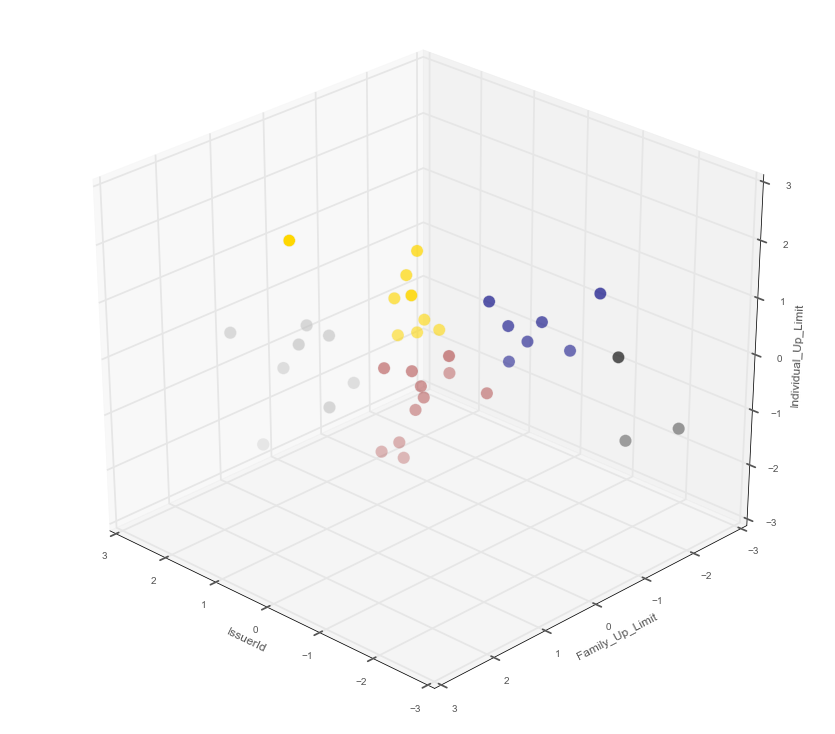

In [103]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
colors = np.array(['brown', 'gold','silver','navy','black'])

ax = Axes3D(plt.figure(figsize=(12, 10)), rect=[.01, 0, 0.95, 1], elev=30, azim=134)
ax.scatter(PlanAttributesData_1_c1.ix[:,'Individual_Up_Limit'], PlanAttributesData_1_c1.ix[:,'Family_Up_Limit'], 
           PlanAttributesData_1_c1.ix[:,'IssuerId'], c = colors[predictions], s=150)
ax.set_xlabel(PlanAttributesData_1_c1.columns[0])
ax.set_ylabel(PlanAttributesData_1_c1.columns[1])
ax.set_zlabel(PlanAttributesData_1_c1.columns[2])

# Conclusion

### The data in this report comes from CMS. After data wangling, we tried to analyse the dataset and predicted some problems. And we found some useful conclusion:
### 1. We used KDE and CDF to find the distribution of family out-of-pocket cost limits .
### 2. We analysed Business Year data by GROUPBY, then found that there is no big price fluctuation in U.S. insurance market in there three years.
### 3. We analysed the state rates, and found that there are fewer plan choices in DE, AK and MS states, the rates of which are much more expensive. You can find why the competition is very important in the health insurance market.
### 4. We analysed the Business Year rates, and found that year 2016 has the lowest rate of Couple-And-Three-Or-More-Dependents, and 2014 has the lowest individual rate in Alaska(AK). And this trend seems to apply to most states.
### 5. We used Regression to predict Family Plan Rate by Individual Rate.
### 6. We used kNN to predict Month by BusinessYear and Individual Rate.
### 7. We used kNN to predict the Couple Rate by Individual Rate.
### 8. We used Naive Bayes and Cluster Modelling to predict State by Rates.
### 9. We used Cluster Modelling to accurately cluster the virsual plans into distinct groups that describe Matel Level without using exact level standard.

# Thnak you!